In [1]:
import torch
import torch.nn as nn
batch_size = 16
# Your model's output logits, shape (batch_size, 4)
logits = torch.randn(batch_size, 4)  # Replace with your actual logits
print(f"logit shape {logits.shape}")
# Ground truth labels as class indices, shape (batch_size,)
labels = torch.randint(4, (batch_size,))  # Replace with your actual labels
print(f"logit shape {labels.shape}")
# Define the Cross-Entropy loss function
criterion = nn.CrossEntropyLoss()

# Compute the loss
loss = criterion(logits, labels)
print(loss)
print(f"loss shape {loss.shape}")

logit shape torch.Size([16, 4])
logit shape torch.Size([16])
tensor(1.8304)
loss shape torch.Size([])


In [2]:
predicted_labels = torch.argmax(logits, dim=1)
print(predicted_labels)
print(labels)

tensor([1, 0, 2, 1, 3, 3, 3, 0, 2, 1, 0, 0, 1, 2, 0, 3])
tensor([3, 2, 2, 0, 0, 2, 0, 0, 3, 0, 3, 2, 3, 1, 0, 0])


In [3]:
from sklearn.metrics import f1_score
correct_predictions = (predicted_labels == labels).sum().item()
accuracy = correct_predictions / batch_size
f1 = f1_score(labels, predicted_labels, average='weighted') 
print(accuracy)
print(f1)

0.3125
0.29743867243867245


In [5]:
import yaml

# Load the configuration from the YAML file
with open('config/config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)


In [6]:
from models.LSTM import LSTMDecoder
from models.Attention import EncoderLayer
from simple_parsing import ArgumentParser
import torch
import torch.nn
from Vocabulary import Vocabulary
from models.Graph_Model import GNNEncoder
args = config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = GNNEncoder(
    args = args,
    cg_layer = 3,
    tg_layer = 3,
    aggregate_method = "mean", 
    input_feat = 514,
    hidden_size = 128,
    output_size = 128,
)
decoder = LSTMDecoder(
    vocab_size = 119, 
    embed_size = 512, 
    hidden_size = 512,  
    batch_size= args["batch_size"], 
    bi_direction = args["lstm_param"]["bi_direction"],
    device = device,
    dropout = args["lstm_param"]["dropout"],
        num_layers = args["lstm_param"]["num_layers"]
    )


In [7]:
# print(list(encoder.softmax.parameters()))
# print(encoder.parameters)

encoder_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
# Create a list of parameters, excluding the final softmax layer
parameters_to_optimize = [p for p in encoder_parameters if p is not encoder.softmax.weight and p is not encoder.softmax.bias]
# print(parameters_to_optimize)

In [3]:
import os
from Vocabulary import Vocabulary
from dataloader import make_dataloader
split = "train"
loader,_ = make_dataloader(
    batch_size = 2,
    split = split,
    base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
    graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
    vocab_path = "vocab_bladderreport.pkl",
    shuffle=True,
    num_workers=4,
    load_in_ram = True
)
print(f"length data loader for {split} is {len(loader)}")

# for word, idx in loader.dataset.vocab.word2idx.items():
#     print(f"Word: {word}, Index: {idx}")
cg,tg,am,cap_to, label, cap, img = next(iter(loader))
print(img.shape)

length data loader for train is 5840


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/z5313504/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/z5313504/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/z5313504/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/z5313504/Desktop/venv/GNN-Histo-Caption/main/dataloader.py", line 224, in __getitem__
    image = Image.open(self.img[graph_id]).convert('RGB')
IndexError: list index out of range


In [9]:
import torchvision
resnet34 = torchvision.models.resnet34(pretrained=True)
with torch.no_grad():
    output = resnet34(img)
print(output.shape)

/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([2, 1000])


In [ ]:
!ls ../../../../../../srv/scratch/bic/peter/Report/Images

In [ ]:
from glob import glob 
all_img = glob(os.path.join("../../../../../../srv/scratch/bic/peter/Report/Images/train","*.png"))
print(len(all_img))
print(all_img[0])


In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
# Load the image using OpenCV
image = Image.open(all_img[0]).convert('RGB')
print(type(image))
print(image.size)

plt.imshow(image)  # OpenCV uses BGR format, so we convert it to RGB for Matplotlib
plt.title("Image")
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
import torchvision
resnet34 = torchvision.models.resnet34(pretrained=True)

In [ ]:
from torchvision import transforms
import torch
preprocess = transforms.Compose([
    transforms.Resize((500, 500)),  # Resize to the desired size
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Apply the preprocessing steps to the image
print(type(image))
input_tensor = preprocess(image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
with torch.no_grad():
    output = resnet34(input_batch)
print(output.shape)

### Example for nn.TransformerDecoder

In [13]:
import torch
import torch.nn as nn

# Define the parameters
d_model = 512  # Model dimension
nhead = 8     # Number of attention heads
num_layers = 6  # Number of decoder layers
dim_feedforward = 2048  # Feedforward dimension

# Create the decoder
dec = nn.TransformerDecoder(
    nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward),
    num_layers,
)

# Input and target sequences
tgt = torch.rand(10, 32, d_model)  # (sequence_length, batch_size, d_model)
memory = torch.rand(1, 32, d_model)  # (sequence_length, batch_size, d_model)

# Output from the decoder
output = dec(tgt, memory)
print(output.shape)

torch.Size([10, 32, 512])


## Transformers


In [3]:
from models.Graph_Model import GNNEncoder
from models.LSTM import LSTMDecoder
from models.GlobalFeatureExtractor import GlobalFeatureExtractor
from models.Classifier import Classifier
from models.Transformer import TransformerDecoder
from models.Attention import EncoderLayer

### Load a data

In [19]:
import os
from dataloader import make_dataloader
from Vocabulary import Vocabulary
split = "train"
loader,dataset = make_dataloader(
    batch_size = 8,
    split = split,
    base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
    graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
    vocab_path = "vocab_bladderreport.pkl",
    shuffle=True,
    num_workers=2,
    load_in_ram = True
)
print(f"length data loader for {split} is {len(loader)}")
cg, tg, assign_mat, caption_tokens, labels, caption, images = next(iter(loader))
print(f"caption token {caption_tokens.shape}")
    # break

length data loader for train is 292
caption token torch.Size([8, 90])


In [21]:
print(labels)


tensor([0, 1, 1, 0, 1, 1, 2, 2])


In [20]:
print(caption_tokens.shape)

torch.Size([8, 90])


### Model Def

In [14]:
args = {
    'gnn_param': {
        'cell_layers': 2,
        'tissue_layers': 2,
        'aggregate_method': 'sum',  # or any other method you prefer
        'hidden_size': 256,
        'output_size': 128,
        'cell_conv_method': "GCN", # GCN, GAT, GraphSage, GIN, PNA
        'tissue_conv_method': "GCN",
    },
    'lstm_param': {
        'size': 128,
        'bi_direction': True,
        'dropout': 0.2,
        'num_layers': 2,
    },
    'global_class_param': {
        'hidden_size': 512,
        'output_size': 128,
        'dropout_rate': 0.1,
    },
    'classifier_param': {
        'hidden_size': 128,
        'num_class': 3,  # adjust according to your task
        'dropout_rate': 0.3,
    },
    'batch_size': 32,  # adjust according to your needs
}
vocab_size = 119
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = DEVICE
# Create Encoder, Attention, Decoder, Global Feature Extractor, and Classifier instances using the args
encoder = GNNEncoder(
    args=args,
    cg_layer=args['gnn_param']['cell_layers'],
    tg_layer=args['gnn_param']['tissue_layers'],
    aggregate_method=args['gnn_param']['aggregate_method'],
    input_feat=514,
    hidden_size=args['gnn_param']['hidden_size'],
    output_size=args['gnn_param']['output_size'],
).to(device)

attention = EncoderLayer(
    d_model=args['gnn_param']['output_size'],
    nhead=4,
    dim_feedforward=1024,
    dropout=0.2
).to(device)

# decoder = TransformerDecoder(
#         vocab_size = vocab_size,
#         d_model = args['gnn_param']['output_size']+args["global_class_param"]["output_size"],
#         nhead = 2, 
#         num_layers = 3, 
#         dim_feedforward=2048, 
#         dropout=0.2
#     ).to(device)

global_feature_extractor = GlobalFeatureExtractor(
    hidden_size=args["global_class_param"]["hidden_size"],
    output_size=args["global_class_param"]["output_size"],
    dropout_rate=args["global_class_param"]["dropout_rate"]
).to(device)

classifier = Classifier(
    graph_output_size=args['gnn_param']['output_size'],
    global_output_size=args["global_class_param"]["output_size"],
    hidden_size=args["classifier_param"]["hidden_size"],
    num_class=args["classifier_param"]["num_class"],
    dropout_rate=args["classifier_param"]["dropout_rate"]
).to(device)

In [15]:
print(encoder.output_size)
print(global_feature_extractor.output_size)
print(classifier.input_size)

128
128
256


In [27]:
features = torch.rand((8,256))
out = classifier(features)
print(out.shape)

a = out.argmax(dim = 1)
print(a)
print(labels)
gt_label = []
pred_label = []
gt_label.extend(labels.tolist())
print(gt_label)
pred_label.extend(a.tolist())

pred_label.extend(labels.tolist())
print(pred_label)

torch.Size([8, 3])
tensor([1, 1, 1, 1, 1, 1, 1, 2])
tensor([0, 1, 1, 0, 1, 1, 2, 2])
[0, 1, 1, 0, 1, 1, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2]


In [7]:
import torch.nn.functional as F
cg = cg.to(DEVICE)
tg = tg.to(DEVICE)
labels = labels.to(DEVICE)
images = images.to(DEVICE)
attention_masks = attention_masks.to(DEVICE)
out = encoder(cg,tg,assign_mat,images) # (batch_size, 1, embedding)
out = F.normalize(out, p=2, dim=1)
print(out.shape)
print(f"min index in graph enc: {torch.min(out)}, max index in tgt: {torch.max(out)}")
global_feat = global_feature_extractor(images)
print(f"min index in global: {torch.min(global_feat)}, max index in tgt: {torch.max(global_feat)}")
print(f"before cat, out {out.shape} global {global_feat.shape}")
merged_feat = torch.cat((out, global_feat), dim=1)

print(merged_feat.shape)
out = merged_feat
# Add debug print statements

print(f"min index in tgt: {torch.min(out)}, max index in tgt: {torch.max(out)}")
print(f"out shape {out.shape} cap tok shape {caption_tokens.shape}")
# out = attention(merged_feat)
lstm_out = decoder(out,caption_tokens)
print(lstm_out.shape)
'''
(sequence_length, batch_size, d_model)
'''


torch.Size([2, 128])
min index in graph enc: -0.2489909678697586, max index in tgt: 0.25518858432769775
min index in global: 0.0, max index in tgt: 2.020029306411743
before cat, out torch.Size([2, 128]) global torch.Size([2, 128])
torch.Size([2, 256])
min index in tgt: -0.2489909678697586, max index in tgt: 2.020029306411743
out shape torch.Size([2, 256]) cap tok shape torch.Size([2, 90])
memory shape torch.Size([2, 256]) tgt shape torch.Size([2, 90])
torch.Size([90, 2, 119])


'\n(sequence_length, batch_size, d_model)\n'

In [10]:
print(lstm_out.shape)
a= torch.argmax(lstm_out,dim=0)
print(a.shape)

torch.Size([90, 2, 119])
torch.Size([2, 119])


## Dealing with Oversampling

In [ ]:
# split = "train"
# _,dataset = make_dataloader(
#     batch_size = 4,
#     split = split,
#     base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
#     graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
#     vocab_path = "vocab_bladderreport.pkl",
#     shuffle=True,
#     num_workers=2,
#     load_in_ram = True
# )
# class_weights = []
# sample_weights = [0]*len(dataset)
# print(f"length dataset is {len(dataset)}")


### WeightRandomSampler

In [29]:
class_count = {
    '0': 0,
    '1': 0,
    '2': 0,
    }

count = 0
class_weight = []
for idx,output in enumerate(dataset):
    _, _, _, _, labels, _, _= output
    if count % 500 == 0 :
        print(count)
    class_count[str(labels)] += 1
    count += 1

print(class_count)
for key,value in class_count.items():
    class_weight.append(1/value)
print(class_weight)
sample_weights = [0]*len(dataset)

for idx, output in enumerate(dataset):
    _, _, _, _, labels, _, _,_= output
    # print(labels.shape)
    class_count[str(labels)] += 1
    sample_weights[idx] = class_weight[labels]
# print(sample_weights)


0
500
1000
1500
2000
{'0': 557, '1': 738, '2': 1041}
[0.0017953321364452424, 0.0013550135501355014, 0.0009606147934678194]


ValueError: not enough values to unpack (expected 8, got 7)

In [31]:

from IPython.utils import io


In [32]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from dataloader import dataset_to_loader
class_weight = [2,1,1]
sampler = WeightedRandomSampler(weights = sample_weights,num_samples = len(dataset),replacement = True)
# print(list(sampler))
with io.capture_output() as captured:
    dl = dataset_to_loader(dataset,batch_size = 8,sampler = sampler, num_workers = 0)
print(len(dl))
dl_count = []

for idx, output in enumerate(dl):
    # print(output)
    # break
    # print(cap.shape)
    # print(lab)
    _, _, _, _, lab, cap, _,_ = output
    print(lab)
    print(cap[0])
    dl_count.extend([i.item() for i in lab])



292


RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)

In [34]:
from collections import Counter
class_distribution = Counter(dl_count)
print(class_distribution)

Counter({1: 797, 2: 773, 0: 766})


## Vocabluary File

In [11]:
# import pickle
# from Vocabulary import Vocabulary

# vocab_file= "vocab_bladderreport.pkl"

# # Load vocabulary from the pickle file
# with open(vocab_file, 'rb') as file:
#     vocab = pickle.load(file)
# # print(vocab)
# # vocab.add_word("<start>")
# # Print all vocabulary items
# print(vocab.print_all_words())
# # print(vocab.word2idx['<start>'])
# # with open(vocab_file, 'wb') as file:
# #     pickle.dump(vocab, file)

# Build a new vocab file

### Relevant Import

In [18]:
import os
import json
import string
import collections
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from Vocabulary import Vocabulary

### Definition

In [16]:

vocab_file = "new_vocab_bladderreport.pkl"
# with open(vocab_file, 'wb') as file:
#     pickle.dump(vocab, file)
base = "../../../../../../srv/scratch/bic/peter/Report"
train_name = "train_annotation.json"
eval_name = "eval_annotation.json"
test_name = "test_annotation.json"
train_path = os.path.join(base,train_name)
eval_path = os.path.join(base,eval_name)
test_path = os.path.join(base,test_name)

### Function to read the vocab file

In [16]:
'''
Reads the file in form
{'name':{'caption':[],'label':x:int}} ==> []
'''
def read_file(file_path):
    all_cap = []
    # Read the JSON file
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    for key, value_dict in data.items():
        for cap in value_dict['caption']:
            all_cap.append(cap)
    return all_cap



In [185]:
train_caption = read_file(train_path)
eval_caption = read_file(eval_path)
test_caption = read_file(test_path)

In [186]:
print(len(train_caption))
print(len(eval_caption))
print(len(test_caption))

11820
4445
5000


In [19]:
vocab = Vocabulary()
# vocab.add_word('1')
print(vocab.print_all_words())

None


In [188]:
'''
exp: "Mild pleomorphism and cytologic atypia is present. There are no signs of crowding in the nuclei."
output:
['Mild', 'pleomorphism', 'and', 'cytologic', 'atypia', 
'is', 'present', 'There', 'are', 'no', 'signs', 'of', 
'crowding', 'in', 'the', 'nuclei']

'''
def word_list_from_cap(caption):
    # caption_no_punctuation = caption.translate(str.maketrans('', '', '.'))
    # # Split the caption into words
    # words = caption_no_punctuation.lower().split()
    words = nltk.tokenize.word_tokenize(str(caption).lower())
    words = [word for word in words if '.' not in word]
    #words = nltk.word_tokenize(text.lower())

    return words

'''
caption_file_list: list of captioning file to get
threshold_freq: only extract words that appear more than this threshold value times

Aim to build the vocabluary file
'''
def build_vocab(all_caption_list,threshold_freq,vocab):
    '''
    add
    <start>
    <pad>
    <end>
    ''' 
    vocab.add_word('<start>')
    vocab.add_word('<pad>')
    vocab.add_word('<end>')
    
    all_words = []
    num_cap = 0
    for cap_list in all_caption_list:
        for cap in cap_list:
            num_cap += 1
            word_list = word_list_from_cap(cap)
            for word in word_list:
                all_words.append(word)
    # print(all_words)
    print(f"total num of caption: {num_cap}")
    counter = collections.Counter(all_words)
    freq_map = dict(counter) # get words frequency
    print(f"total word is {len(freq_map)}")
    # print(freq_map)
    for word,freq in  freq_map.items():
        if freq < threshold_freq:
            print(f"word {word}: freq = {freq}")
            continue
        vocab.add_word(word)
    return vocab, freq_map

Total number of caption: **21265** \
Total number of word in all three captioning file is: **127** \
Least appeared word is **appear**: **181** times in total. \
Training caption number: **127**  \
Thus it covers all words

In [173]:
'''
least appeared word is appear:  train_caption, eval_caption, test_caption

only train 24613: is
all caption
'''
vocab,freq_map = build_vocab([train_caption, eval_caption, test_caption],100,vocab)

total num of caption: 21265
total word is 112


45212


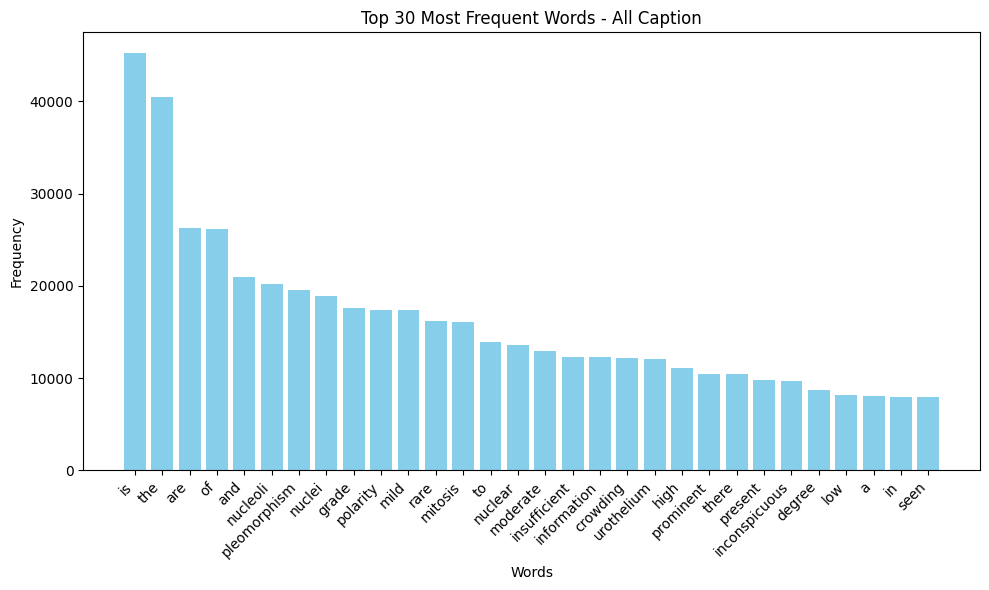

In [174]:
print(freq_map["is"])
# Sort the dictionary by values to get the most frequent words
sorted_words = sorted(freq_map.items(), key=lambda x: x[1], reverse=True)

# Select top 20 most frequent words for plotting
top_words = dict(sorted_words[:30])

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values(), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Words - All Caption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

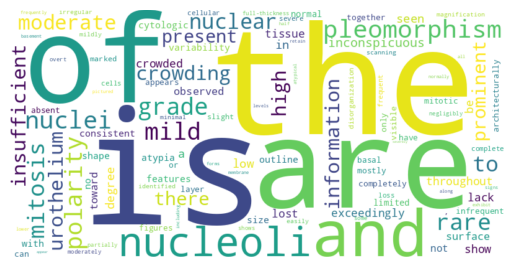

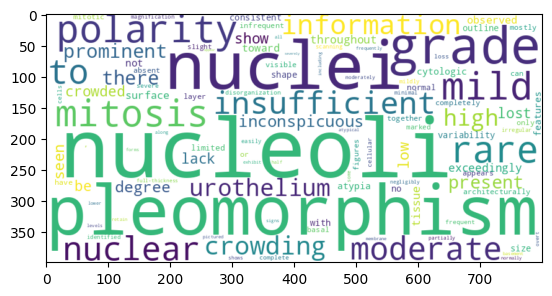

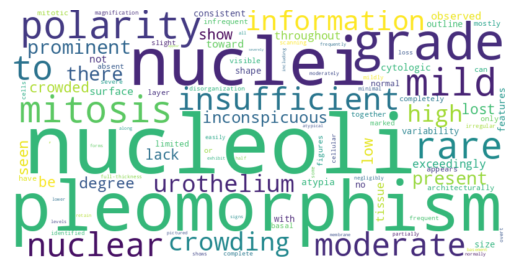

In [175]:
# text = " ".join([(k + " ")*v for k,v in freq_map.items()])

# # Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(freq_map)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
clean_freq_map = freq_map.copy()
keys_to_remove = ['is','are','of','the','a','in','and']
for key in keys_to_remove:
    if key in clean_freq_map:
        del clean_freq_map[key]


# lower max_font_size
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(clean_freq_map)
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



### Write to a pkl file

In [179]:
# with open(vocab_file, 'wb') as file:
#     pickle.dump(vocab, file)

### Load it and read it

In [3]:
import pickle
vocab_file= "new_vocab_bladderreport.pkl"

# Load vocabulary from the pickle file
with open(vocab_file, 'rb') as file:
    vocabs = pickle.load(file)
print(len(vocabs))

115


In [191]:
embed = torch.tensor([ 0, 33, 79, 89, 88, 19, 62, 92, 98, 19, 18, 48, 98, 19, 62,  5, 65, 23,
        88,  5,  5, 65, 95, 65, 26, 89, 92, 89, 79, 89, 79, 95, 65, 95, 54, 89,
        79, 49, 79, 89, 79, 49, 79, 95, 65,  0, 65,  5, 96, 80])

In [197]:
sentence = " ".join([vocabs.idx2word[int(idx)] for idx in embed])

sentence = sentence.replace("<pad>","").replace("<start>","")
sentence = ' '.join(sentence.split()).replace("<end>", ".")
print(sentence)

not appear low identified membrane visible cells all membrane basement absent all membrane visible is or rare identified is is or atypical or nucleoli low cells low appear low appear atypical or atypical , low appear slight appear low appear slight appear atypical or or is forms moderate


## Dataset Show

In [4]:
!ls ../../../../../../srv/scratch/bic/peter/Report/Images

eval  test  train


In [6]:
import os
import json
image_base = "../../../../../../srv/scratch/bic/peter/Report/Images"
img_split = "train"
train_img_dir = os.path.join(image_base,img_split)
base = "../../../../../../srv/scratch/bic/peter/Report"
train_name = "train_annotation.json"
train_cap_path = os.path.join(base,train_name)

In [7]:
with open(train_cap_path, 'r') as json_file:
    train_data = json.load(json_file)
    # print(data)

In [8]:
# !ls ../../../../../../srv/scratch/bic/peter/Report/Images/train

2364
Full filename: 118201_010.png
Filename without extension: 118201_010
['Moderate pleomorphism and cytologic atypia is present. Mild crowding of the nuclei can be seen. Polarity is completely lost. Mitosis is frequent. The nucleoli of nuclei are prominent. High grade.', 'Nuclear features show moderate pleomorphism. Mild nuclear crowding is seen. Architecturally the cells show complete lack of polarity toward the surface urothelium. Mitosis is frequent throughout the tissue. Nucleoli are prominent and irregular. High grade.', 'Moderate pleomorphism and cytologic atypia is present. Nuclei are mildly crowded together. Polarity is completely lost. There are frequent mitotic figures throughout the tissue. Nucleoli is prominent. High grade.', 'Moderate pleomorphism is present. Mild nuclear crowding is seen. Polarity is completely lost. Mitosis is frequent throughout the tissue. Nucleoli is prominent. High grade.', 'Minimal variability in nuclear size shape and outline consistent with mode

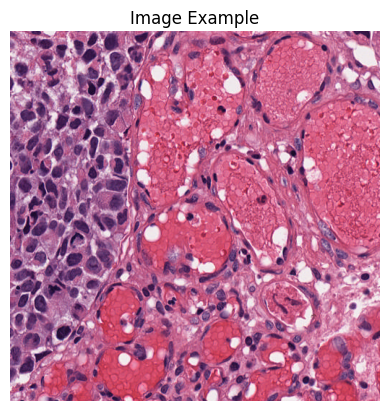

In [35]:
import glob
import random
import cv2
import matplotlib.pyplot as plt


all_files = glob.glob(train_img_dir + '/*.png')
print(len(all_files))

def find_one(all_files):
    length = len(all_files)
    idx = random.randint(0,length)
    img_name = all_files[idx]
    directory, full_filename = os.path.split(img_name)
    filename, extension = os.path.splitext(full_filename)
    
    print("Full filename:", full_filename)
    print("Filename without extension:", filename)
    return img_name, filename

img_path, pure_name = find_one(all_files)
# img_path = "../../../../../../srv/scratch/bic/peter/Report/Images/train/118345_012.png"
# pure_name = "118345_012"
caption = train_data[pure_name]['caption']
print(caption)

# Open the image file
image = cv2.imread(img_path)
# dir_name, img_name = os.path.split(image_path)
# # Convert the BGR image to RGB (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.title("Image Example")
plt.axis('off')  # Hide the axis
plt.show()

## Generate and Visualise Graph

In [23]:
import sys
import numpy as np
from PIL import Image
sys.path.append('../histocartography/histocartography')
sys.path.append('../histocartography')
from histocartography.preprocessing import NucleiExtractor, DeepFeatureExtractor, KNNGraphBuilder, RAGGraphBuilder, ColorMergedSuperpixelExtractor
nuclei_detector = NucleiExtractor()
tissue_detector = ColorMergedSuperpixelExtractor(
    superpixel_size=500,
    compactness=30,
    blur_kernel_size=1,
    threshold=0.05,
    downsampling_factor=4
)
tissue_feature_extractor = DeepFeatureExtractor(
            architecture='resnet34',
            patch_size=144,
            resize_size=224
        )
rag_graph_builder = RAGGraphBuilder(add_loc_feats=True)
feature_extractor = DeepFeatureExtractor(architecture='resnet34', patch_size=72)
knn_graph_builder = KNNGraphBuilder(k=3, thresh=70, add_loc_feats=True)
image = np.array(Image.open(img_path))
nuclei_map, _ = nuclei_detector.process(image)
features = feature_extractor.process(image, nuclei_map)
cell_graph = knn_graph_builder.process(nuclei_map, features)

UnpicklingError: invalid load key, '\x0a'.

In [ ]:
from histocartography.visualization import OverlayGraphVisualization, InstanceImageVisualization

visualizer = OverlayGraphVisualization(
    instance_visualizer=InstanceImageVisualization(
    instance_style="filled+outline"
    )
)
viz_cg = visualizer.process(
     canvas=image,
     graph=cell_graph,
     instance_map=nuclei_map
 )

viz_cg.show()

In [ ]:
visualizer = OverlayGraphVisualization(
    instance_visualizer=InstanceImageVisualization(
    instance_style="filled+outline"
    )
)
viz_tg = visualizer.process(
     canvas=image,
     graph=tissue_graph,
     instance_map=superpixels
 )

viz_tg.show()

## Show the one generated

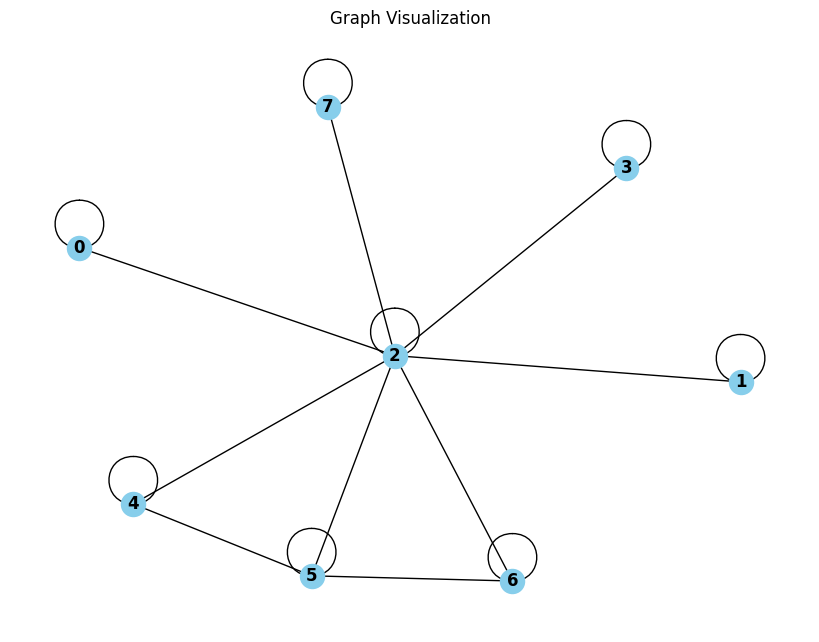

In [34]:
import networkx as nx
import dgl
graph_path = "../../../../../../srv/scratch/bic/peter/full-graph/tissue_graphs/train/118345_012.bin"
graph = dgl.load_graphs(graph_path)[0][0]  # Assuming there's only one graph per file
# Convert DGL graph to NetworkX graph
nx_graph = graph.to_networkx().to_undirected()  # Convert to NetworkX graph

# Plotting the NetworkX graph
plt.figure(figsize=(8, 6))
nx.draw(nx_graph, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold')
plt.title('Graph Visualization')
plt.show()


## Inference

In [9]:
import sys
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import torchvision.transforms as transforms
import dgl
import ssl
import os
import h5py
import networkx as nx
from graph_generation import GraphBuilding
from Vocabulary import Vocabulary
ssl._create_default_https_context = ssl._create_unverified_context # Use it to solve SSL 

In [4]:
def get_all_models(model_base_path,encoder_name,global_extractor_name,decoder_name,device): 
    # current_directory = os.getcwd()

    encoder_path = os.path.join(model_base_path,encoder_name)
    global_feat_path = os.path.join(model_base_path,global_extractor_name)
    decoder_path = os.path.join(model_base_path,decoder_name)
    if os.path.exists(encoder_path):
        # load
        print(f"exists")
        encoder = torch.load(encoder_path).to(device)
        pass
    else:
        raise Exception(f"Encoder path {encoder_path} not exist")
    
    if os.path.exists(global_feat_path):
        # load
        global_feat_extractor = torch.load(global_feat_path).to(device)
        pass
    else:
        raise Exception(f"Encoder path {encoder_path} not exist")

    if os.path.exist(decoder_path):
        # load
        decoder = torch.load(torch.load(decoder_path)).to(device)
    else:
        raise Exception(f"Encoder path {decoder_path} not exist")
    return encoder,global_feat_extractor,decoder

In [ ]:
image_path
target_path
GB = GraphBuilding(target_path)
GB.build_single(image_path,"graph")

In [10]:
def inference(encoder, global_feat_extractor, decoder, image_path,  cg_path,tg_path,assign_mat_path, vocab, device):
    def h5_to_tensor(h5_path):
        h5_object = h5py.File(h5_path, 'r')
        out = torch.from_numpy(np.array(h5_object['assignment_matrix']))
    return out
    # get image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((500,500)),
        transforms.ToTensor(),
    ])
    # get cg
    cg = load_graphs(cg_path)[0][0]
    #get tg
    tg = load_graphs(tg_path)[0][0]

    #get assign_mat
    assign_mat = h5_to_tensor(assign_mat_path)
    

    # Apply the transformation to the image
    image = transform(image)
    out = encoder(cg,tg,assign_mat,image)
    global_feat = global_feature_extractor(image)
    merged_feat = torch.cat((out, global_feat), dim=1)
    lstm_out, _= decoder.predict(merged_feat,90)
    sentence = " ".join([loader.dataset.vocab.idx2word[int(idx)] for idx in lstm_out])
    sentence = sentence.replace("<pad>","").replace("<start>","")
    sentence = ' '.join(sentence.split()).replace("<end>", ".")
    return sentence

In [36]:
!ls ../../model-save

Decoder1-73-2.58.pt         Encoder4-38-2.43.pt
Decoder1-99-2.76.pt         Encoder4-99-2.79.pt
Decoder2-11-2.69.pt         Encoder5-47-2.37.pt
Decoder2-99-2.95.pt         Encoder5-99-2.70.pt
Decoder3-14-2.46.pt         Encoder6-0-2.57.pt
Decoder3-99-3.04.pt         Encoder6-99-2.83.pt
Decoder4-38-2.43.pt         GlobalExtractor1-73-2.58.pt
Decoder4-99-2.79.pt         GlobalExtractor1-99-2.76.pt
Decoder5-47-2.37.pt         GlobalExtractor2-11-2.69.pt
Decoder5-99-2.70.pt         GlobalExtractor2-99-2.95.pt
Decoder6-0-2.57.pt          GlobalExtractor3-14-2.46.pt
Decoder6-99-2.83.pt         GlobalExtractor3-99-3.04.pt
Encoder1-73-2.58.pt         GlobalExtractor4-38-2.43.pt
Encoder1-99-2.76.pt         GlobalExtractor4-99-2.79.pt
Encoder2-11-2.69.pt         GlobalExtractor5-47-2.37.pt
Encoder2-99-2.95.pt         GlobalExtractor5-99-2.70.pt
Encoder3-14-2.46.pt         GlobalExtractor6-0-2.57.pt
Encoder3-99-3.04.pt         GlobalExtractor6-99-2.83.pt


In [38]:
model_base_path = "../../model-save"
encoder_name  = "Encoder4-38-2.43.pt"
global_extractor_name = "GlobalExtractor4-38-2.43.pt"
decoder_name = "Decoder4-38-2.43.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder, global_feature_extractor, decoder = get_all_models(model_base_path,encoder_name, global_extractor_name,decoder_name,device)

cpu
exists


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = "../../Report-nmi-wsi/Images/train/118201_010.png"
cg_path = "../../graph/cell_graphs/train/118201_010.bin"
tg_path = "../../graph/tissue_graphs/train/118201_010.bin"
assign_mat_path = "../../graph/assignment_mat/train/118201_010.h5"
vocab_file= "new_vocab_bladderreport.pkl"

# Load vocabulary from the pickle file
with open(vocab_file, 'rb') as file:
    vocab = pickle.load(file)
inference(encoder,global_feature_extractor,decoder, image_path,cg_path,tg_path,assign_mat_path,vocab_file,device)